# **SET-UP**

In this section, the relavant libraries are imported, and the training, validation and test datasets are prepared.

If the notebook is running on Google Colab, the data can be downloaded to the environment by running the corresponding cell.

In [1]:
# imports

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

This cell should only be executed if the notebook is running on Google Colab.

If the notebook is running locally with the data already situated in the correct directory, this cell block should **not** be run.

In [2]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=21ba3f0d-7611-42f8-9a35-643615f0a45b
To: /content/data.zip
100% 289M/289M [00:03<00:00, 74.8MB/s]


In [3]:
# download if zip files not already downloaded
if not os.path.exists('utils.zip'):
    !gdown '1gpmibySGF2wxCMRcE_0V9duUf27U5270'
else:
    print('utils.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('utils'):
    !unzip -qq utils.zip
    !rm utils.zip
else:
    print('utils folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1gpmibySGF2wxCMRcE_0V9duUf27U5270
To: /content/utils.zip
100% 2.85k/2.85k [00:00<00:00, 15.6MB/s]


In [4]:
# download if zip files not already downloaded
if not os.path.exists('depth_estimation.zip'):
    !gdown '13mGFBWNPAT2_JPMJq6244O4NYnLpsWrr'
else:
    print('depth_estimation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('depth_estimation'):
    !unzip -qq depth_estimation.zip
    !rm depth_estimation.zip
else:
    print('depth_estimation folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=13mGFBWNPAT2_JPMJq6244O4NYnLpsWrr
From (redirected): https://drive.google.com/uc?id=13mGFBWNPAT2_JPMJq6244O4NYnLpsWrr&confirm=t&uuid=c5589c48-dcf7-45ac-b2ed-a9cffe485860
To: /content/depth_estimation.zip
100% 61.2M/61.2M [00:00<00:00, 82.3MB/s]


## Constructing Datasets

Informally experimenting with various batch sizes,demonstrated that a batch size of four yielded the best results.

In [5]:
# batch size
B = 4

The appropriate transformations can be applied for training, validation and test data. The dataset is split into 60% for training data, 10% for validation data, and 30% for test data.

In [6]:
from torch.utils.data import random_split, DataLoader
from utils.seq_dataset import SeqDataset
from utils.data_management import get_transform, initialize_loader

# set up dataset
dataset = SeqDataset(root_dir='data', transform=None)

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# dataloaders
train_loader = initialize_loader(train_dataset, get_transform("train"), B, True)
val_loader = initialize_loader(val_dataset, get_transform("validation"), B, False)
test_loader = initialize_loader(test_dataset, get_transform("test"), B, False)

### Visualize Data

This cell can be optionally executed to visualize the structure of the dataset.

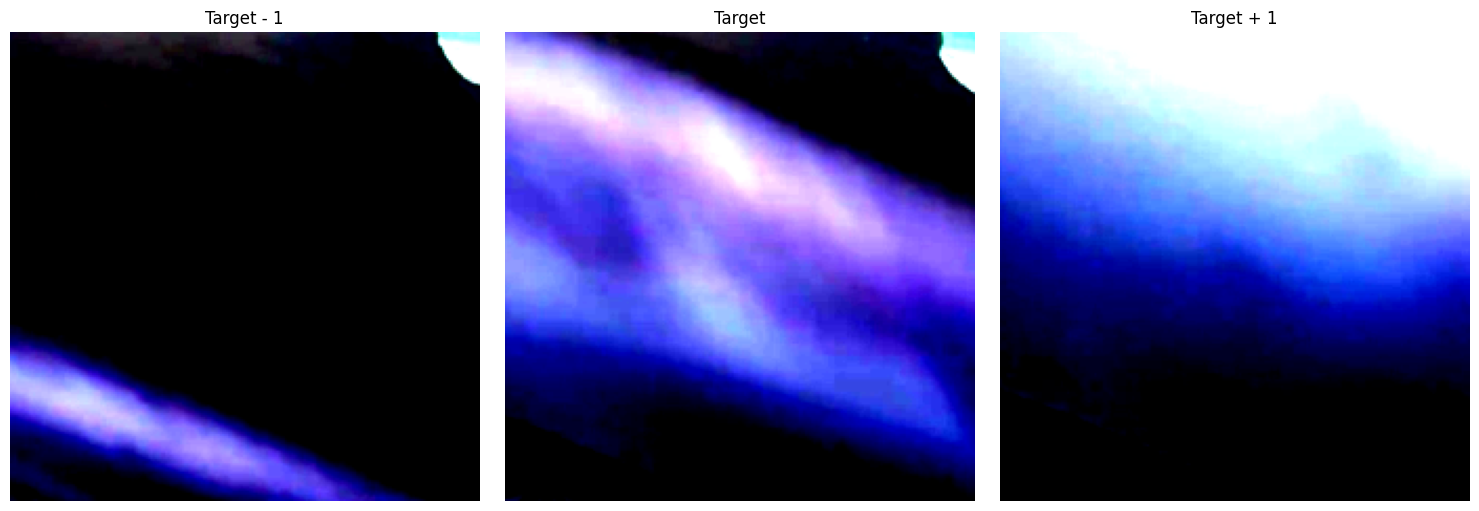

In [7]:
tgt, [s1, s2] = train_dataset[10]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy().clip(0,1))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy().clip(0,1))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy().clip(0,1))
plt.axis('off')

plt.tight_layout()
plt.show()

## Save/Load Functions

In [8]:
from depth_estimation.depth_net import DepthNet
from depth_estimation.pose_net import PoseNet

def load_depth():
    depth = DepthNet()
    depth.load_state_dict(torch.load("depth_estimation/weights/depth_B.pth", map_location=torch.device('cpu')))
    depth.eval()
    return depth

def load_pose():
    pose = PoseNet()
    pose.load_state_dict(torch.load("depth_estimation/weights/pose_B.1_weights.pth", map_location=torch.device('cpu')))
    pose.eval()
    return pose

def load_backbone():
    backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    backbone.eval()
    return backbone

In [9]:
from google.colab import files

def save_weights(model, id):
    name = f"{type}_{id}.pth"
    torch.save(model.state_dict(), name)
    files.download(name)

# **ARCHITECTURE**

In [10]:
import torch
import torch.nn as nn

# slot attention module with fixed S=10 slots
class SlotAttention(nn.Module):
    def __init__(self, num_slots: int, dim: int, iters: int = 3, mlp_hidden: int = 256):
        super().__init__()
        # fixed variables
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5

        # computation
        self.avg = nn.Parameter(torch.randn(1, 1, dim))
        self.logvar = nn.Parameter(torch.zeros(1, 1, dim))

        # attention layers
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim+1, dim, bias=False)
        self.to_v = nn.Linear(dim+1, dim, bias=False)

        # refinement layers
        self.gru = nn.GRUCell(dim, dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden), nn.ReLU(inplace=True), nn.Linear(mlp_hidden, dim)
        )

        # norm layers
        self.norm_inputs = nn.LayerNorm(dim+1)
        self.norm_slots  = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)

    # initialize slots with noise
    def intialize_slots(self, B):
        mu = self.avg.expand(B, self.num_slots, -1)
        sigma = self.logvar.exp().expand(B, self.num_slots, -1)
        noise = torch.randn_like(mu)
        return mu + sigma * noise

    # attention computation
    def compute_attn(self, q, k):
        logits = torch.einsum('bsc,bnc->bsn', q, k) * self.scale
        attn = logits.softmax(dim=1) + 1e-8
        attn = attn / attn.sum(dim=2, keepdim=True)
        return attn

    def forward(self, feats: torch.Tensor):
        B,N,C_in = feats.shape
        C = self.to_q.out_features

        # initialize slots
        slots = self.intialize_slots(B)

        # keys, values
        k = self.to_k(self.norm_inputs(feats))
        v = self.to_v(feats)

        # attention
        for _ in range(self.iters):
            slots_prev = slots
            q = self.to_q(self.norm_slots(slots))
            attn = self.compute_attn(q, k)
            updates = torch.einsum('bsn,bnc->bsc', attn, v)

            slots = self.gru(updates.reshape(-1, C), slots_prev.reshape(-1, C)).view(B,-1,C)
            slots = slots + self.mlp(self.norm_pre_ff(slots))

        return slots

In [11]:
import torch
import torch.nn as nn

# mask decoder
class MaskDecoder(nn.Module):
    def __init__(self, feat_dim: int, slot_dim: int):
        super().__init__()
        # project slots to feature space
        self.slot_proj = nn.Linear(slot_dim, feat_dim+1)

    def forward(self, slots: torch.Tensor, feat_map: torch.Tensor) -> torch.Tensor:
        # get shapes
        B,S,D = slots.shape
        B,C,H,W = (4, 768, 16, 16)

        # project slots
        q = self.slot_proj(slots)

        # compute attention
        attn = torch.einsum('bsc,bnc->bsn', q, feat_map)
        attn = attn.softmax(dim=1)

        # reshape to spatial masks
        masks = attn.view(B,S,H,W)
        return masks

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from depth_estimation.depth_trainer import pose_vec2mat

# object detection module
class ObjectDetector(nn.Module):
    def __init__(self, num_slots, feat_dim):
        super().__init__()
        self.feat_dim = feat_dim
        self.dino = load_backbone()
        self.depth_net = load_depth()
        self.slot_attn = SlotAttention(num_slots, feat_dim)
        self.mask_decoder = MaskDecoder(feat_dim, feat_dim)
        self.num_slots = num_slots

    # construct feature vector with masks and depth
    @staticmethod
    def compute_object_features(feat_map_flat, depth_flat, masks_flat):
        obj_feats = torch.einsum("bsh,bch->bsc", masks_flat, feat_map_flat)
        obj_feats = obj_feats / (masks_flat.sum(dim=-1, keepdim=True) + 1e-8)
        masked_depth = torch.einsum("bsh,bch->bsc", masks_flat, depth_flat)
        masked_depth = masked_depth / (masks_flat.sum(dim=-1, keepdim=True) + 1e-8)
        obj_feats = torch.cat([obj_feats, masked_depth], dim=-1)
        return obj_feats

    # compute confidence score from masks and bounding boxes
    @staticmethod
    def compute_confidence(masks, bboxes, min_area=5):
        B, S, H, W = masks.shape
        flat_masks = masks.view(B, S, -1)

        # activation
        avg_score = flat_masks.mean(dim=-1)
        peak_score = flat_masks.max(dim=-1).values

        # bbox area check
        widths = (bboxes[..., 2] - bboxes[..., 0]).clamp(min=0)
        heights = (bboxes[..., 3] - bboxes[..., 1]).clamp(min=0)
        box_area = widths * heights
        valid_box = (box_area > min_area).float()

        # weighted sum
        confidence = 0.6 * avg_score + 0.4 * peak_score
        confidence = confidence * valid_box

        return confidence

    # move all models to device
    def set_device(self, device):
        self.to(device)
        self.dino.to(device)
        self.depth_net.to(device)
        self.slot_attn.to(device)
        self.mask_decoder.to(device)

    # use backbone to get image features
    def extract_features(self, img):
        flat = self.dino.get_intermediate_layers(img, n=1)[0]
        B, N, C = flat.shape
        H = W = int(N ** 0.5)
        features = flat.transpose(1, 2).reshape(B, C, H, W)
        return flat, features

    # get depth
    def get_depth(self, img):
        return self.depth_net(img)

    # get pose
    def get_pose(self, img):
        return pose_vec2mat(self.pose_net(img))

    # get masks from slot attention + mask decoder
    def get_masks(self, feat, depth):
        B = feat.shape[0]
        depth_feats = torch.cat([feat, depth], dim=-1)
        slots = self.slot_attn(depth_feats)
        masks = self.mask_decoder(slots, depth_feats)
        masks_flat = masks.view(B, self.num_slots, -1)
        return slots, masks, masks_flat

    # use masks to compute bounding boxes
    def get_bounding_boxes(self, masks):
        # storing bounding boxes for slots
        bboxes = []
        B = masks.shape[0]

        # iterate over batches
        for b in range(B):
            boxes_batch = []
            for s in range(self.num_slots):
                # nonzero pixels
                mask = masks[b, s]
                ys, xs = torch.where(mask > 0.5 * mask.max())

                if len(xs) == 0 or len(ys) == 0:
                    # empty masks
                    boxes_batch.append(torch.tensor([0,0,0,0], device=mask.device))
                else:
                    # min max corners
                    x1, x2 = xs.min().item(), xs.max().item()
                    y1, y2 = ys.min().item(), ys.max().item()
                    boxes_batch.append(torch.tensor([x1, y1, x2, y2], device=mask.device))

            # stack batch boxes
            bboxes.append(torch.stack(boxes_batch))

        # stack all batches
        bboxes = torch.stack(bboxes)
        return bboxes

    # forward pass
    def forward(self, x):
        B = x.shape[0]

        # get features
        feat_map_flat, feat_map = self.extract_features(x)

        # get depth and prep for processing
        depth = self.get_depth(x)
        depth_down = F.interpolate(depth, size=(16, 16), mode='bilinear', align_corners=False)
        depth_flat = depth_down.view(B, 1, -1)

        # get final values
        slots, masks, masks_flat = self.get_masks(feat_map_flat, depth_flat.permute(0, 2, 1))
        obj_feats = self.compute_object_features(feat_map_flat.view(B, 768, -1), depth_flat, masks_flat)
        bboxes = self.get_bounding_boxes(masks)
        conf = self.compute_confidence(masks, bboxes)
        return feat_map, depth, slots, masks, bboxes, obj_feats, conf

# **TOOLS**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Helper Functions

#### Calculations

#### Visualization

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_masks_and_boxes(img: torch.Tensor, masks: torch.Tensor, bboxes: torch.Tensor, alpha=0.5):
    H, W = img.shape[1:]
    img_np = img.permute(1,2,0).cpu().numpy()

    # Overlay masks
    overlay = img_np.copy()
    colors = plt.colormaps["tab10"].colors[:masks.shape[0]]
    for i in range(masks.shape[0]):
        mask_np = masks[i].cpu().numpy()
        color = colors[i][:3]
        overlay = (1-alpha)*overlay + alpha*mask_np[...,None]*color
    overlay = np.clip(overlay, 0, 1)

    # Draw boxes
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(overlay)
    for box in bboxes.cpu().numpy():
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
        axs[1].add_patch(rect)
    axs[1].set_title("Masks + Boxes Overlay")
    axs[1].axis('off')

    plt.show()

### Loss Functions

In [15]:
# mask reconstruction: guide slots to reconstruct feature map
def mask_reconstruction_loss(feat_map_flat, masks_flat, slot_feats):
    B, S, HW = masks_flat.shape
    _, C, _ = feat_map_flat.shape

    # weighted sum of slots using masks
    recon = torch.einsum('bsh,bsc->bch', masks_flat, slot_feats)

    # mse between reconstruction and original features
    loss = F.mse_loss(recon, feat_map_flat)
    return loss

In [16]:
# mask entropy: encourage confident masks
def mask_entropy_loss(masks_flat):
    p = masks_flat.clamp(1e-6, 1-1e-6)
    loss = -(p * torch.log(p) + (1 - p) * torch.log(1 - p))
    return loss.mean()

In [17]:
# depth edge alignment: encourage masks to align with depth edges
def depth_edge_loss(masks_flat, depth_map):
    # compute depth gradients
    grad_x = torch.abs(depth_map[:, :, :, 1:] - depth_map[:, :, :, :-1])
    grad_y = torch.abs(depth_map[:, :, 1:, :] - depth_map[:, :, :-1, :])

    # downsample to mask resolution
    grad_x_down = F.interpolate(grad_x, size=(16, 16), mode='bilinear', align_corners=False)
    grad_y_down = F.interpolate(grad_y, size=(16, 16), mode='bilinear', align_corners=False)

    # sum edges
    depth_edges = grad_x_down + grad_y_down

    # flatten edges
    depth_edges_flat = depth_edges.view(depth_edges.size(0), 1, -1)

    # compute weighted sum with masks
    loss = torch.einsum('bsh,bch->bsc', masks_flat, depth_edges_flat).mean()
    return loss

In [18]:
# mask orthogonality: encourage masks to be distinct
def mask_orthogonality_loss(masks_flat):
    B, S, HW = masks_flat.shape
    loss = 0.0
    for b in range(B):
        mask = masks_flat[b]

        # dot product between masks
        dot = torch.matmul(mask, mask.T)

        # remove self-dot terms
        dot = dot - torch.diag(torch.diag(dot))

        # average off-diagonal terms
        loss += dot.sum() / (S*(S-1))
    return loss / B

### Training loop

In [19]:
def train(detector, optimizer, tracked_loss, compute_loss, device, epochs=50):
    # reset the tracked losses
    tracked_loss = []
    sw = 0.1

    # training loop
    for epoch in range(epochs):
        print(f"\nEPOCH {epoch + 1} -----------------------------")

        # loss tracking variables
        total_loss = 0.0
        num_batches = 0

        # iterate over batches
        for input_data in train_loader:
            # unpack data
            tgt, [src1, src2] = input_data
            tgt = tgt.to(device)
            src1 = src1.to(device)
            src2 = src2.to(device)

            # forward pass
            output = detector(tgt)

            # loss compuation
            loss = compute_loss(tgt, output)

            # backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # track loss
            total_loss += loss.item()
            num_batches += 1

        # track loss over epochs
        avg_loss = total_loss / num_batches
        tracked_loss.append(avg_loss)

        # print loss
        print(f"[average loss: {avg_loss:.4f}]")

In [20]:
def inter(tgt, output):
    _, _, masks, bboxes, _, _ = output
    print(masks.shape)
    print(bboxes.shape)
    H_img, W_img = 224, 224
    H_mask, W_mask = 16, 16

    # bboxes shape: [num_boxes, 4], each box: [x1, y1, x2, y2] in mask coordinates
    scale_x = W_img / W_mask
    scale_y = H_img / H_mask

    bboxes_scaled = bboxes.clone()
    bboxes_scaled[:, 0] = bboxes[:, 0] * scale_x  # x1
    bboxes_scaled[:, 2] = bboxes[:, 2] * scale_x  # x2
    bboxes_scaled[:, 1] = bboxes[:, 1] * scale_y  # y1
    bboxes_scaled[:, 3] = bboxes[:, 3] * scale_y  # y2
    masks_up = F.interpolate(masks, size=(224, 224), mode='bilinear', align_corners=False)
    print(masks_up.shape)
    with torch.no_grad():
        visualize_masks_and_boxes(tgt[0], masks_up[0], bboxes_scaled[0])
    assert(False)

# **TRAINING**

In [21]:
# object detection loss: combine losses
def object_detection_loss(tgt, values, lambda_recon=1.0,lambda_entropy=0.1,lambda_ortho=0.1,lambda_depth=0.1):
    # unpack values
    features, depth_map, slots, masks, _, _, _ = values

    # compute flat values
    masks_flat = masks.view(B, 10, -1)
    feat_map_flat = features.view(B, 768, -1)

    # compute losses
    loss = lambda_recon * mask_reconstruction_loss(feat_map_flat, masks_flat, slots)
    loss += lambda_entropy * mask_entropy_loss(masks_flat)
    loss += lambda_ortho * mask_orthogonality_loss(masks_flat)
    loss += lambda_depth * depth_edge_loss(masks_flat, depth_map)
    return loss


In [22]:
obj_dec = ObjectDetector(10, 768)
obj_dec.set_device(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 195MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 98.1MB/s]


In [23]:
params = list(obj_dec.parameters())

# optimizer with learning rate 1e-4
optimizer = torch.optim.Adam(params, lr=1e-4)

In [24]:
train(obj_dec, optimizer, [], object_detection_loss, device, epochs=20)


EPOCH 1 -----------------------------
[average loss: 0.1508]

EPOCH 2 -----------------------------
[average loss: 0.0901]

EPOCH 3 -----------------------------
[average loss: 0.0837]

EPOCH 4 -----------------------------
[average loss: 0.0628]

EPOCH 5 -----------------------------
[average loss: 0.0635]

EPOCH 6 -----------------------------
[average loss: 0.0709]

EPOCH 7 -----------------------------
[average loss: 0.0718]

EPOCH 8 -----------------------------
[average loss: 0.0536]

EPOCH 9 -----------------------------
[average loss: 0.0544]

EPOCH 10 -----------------------------
[average loss: 0.0523]

EPOCH 11 -----------------------------
[average loss: 0.0504]

EPOCH 12 -----------------------------
[average loss: 0.0484]

EPOCH 13 -----------------------------
[average loss: 0.0455]

EPOCH 14 -----------------------------
[average loss: 0.0466]

EPOCH 15 -----------------------------
[average loss: 0.0419]

EPOCH 16 -----------------------------
[average loss: 0.0486]



In [25]:
save_weights(obj_dec,"A")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
import matplotlib.patches as patches

def visualize_bboxes(img, bboxes):
    img = img.permute(1, 2, 0).cpu().numpy().clip(0,1)
    bboxes = bboxes * (224//16)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    for box in bboxes.cpu().numpy():
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


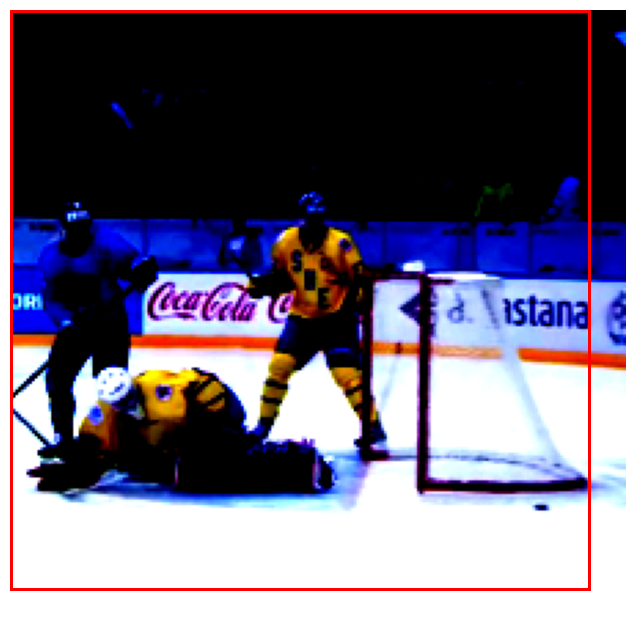

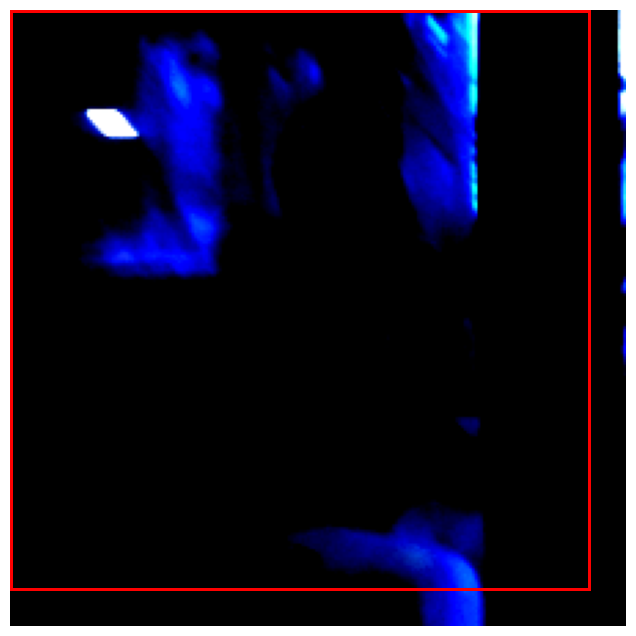

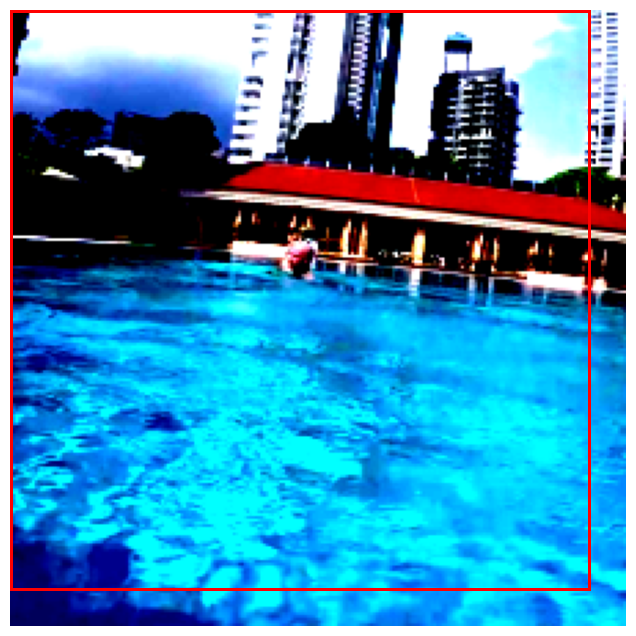

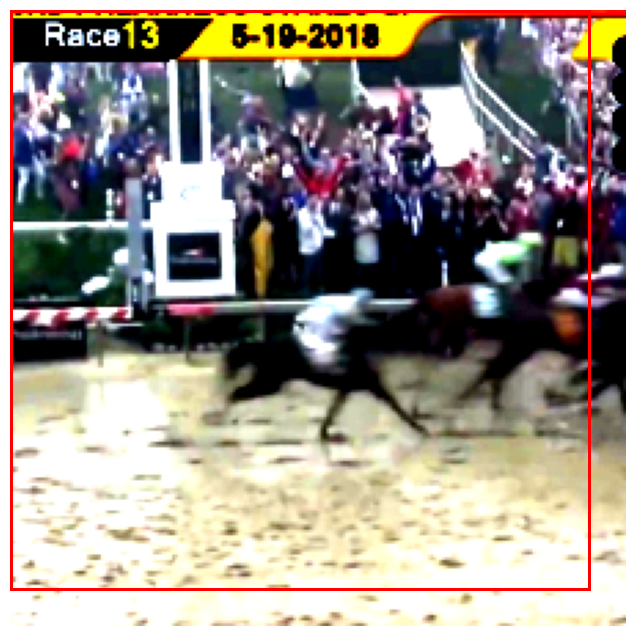

In [54]:
with torch.no_grad():
    for tgt, _ in val_loader:
        tgt = tgt.to(device)
        feat_map, depth, slots, masks, bboxes, obj_feats, conf= obj_dec(tgt)
        for i in range(4):
            visualize_bboxes(tgt[i], bboxes[i])
        break

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


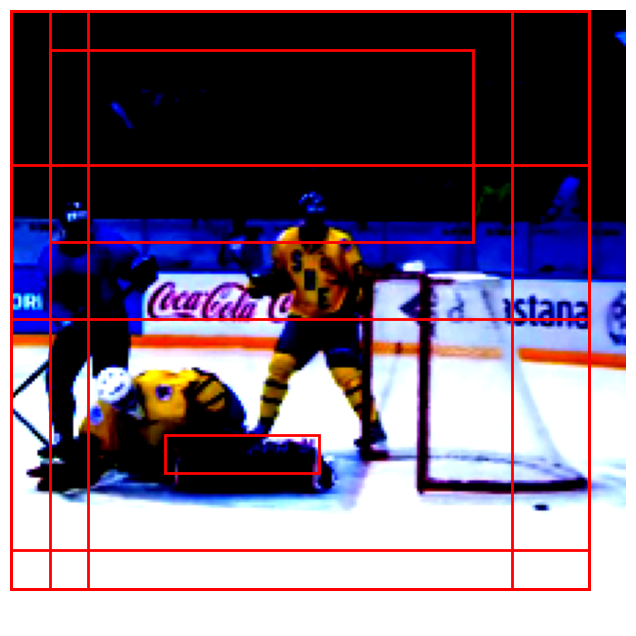

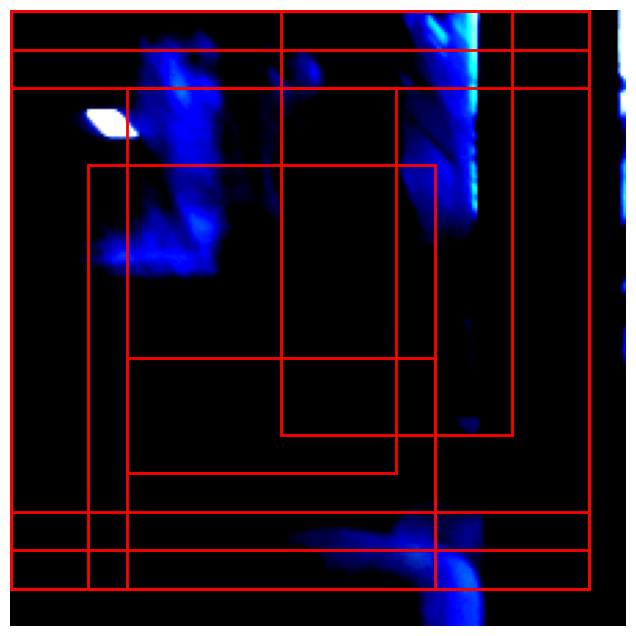

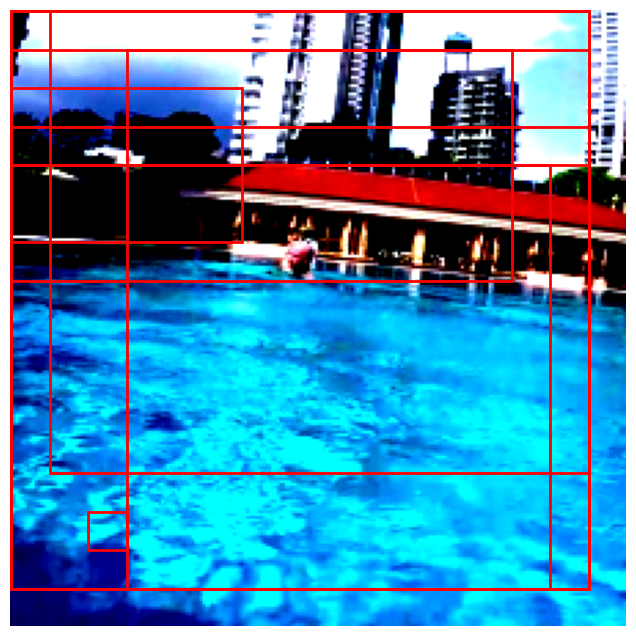

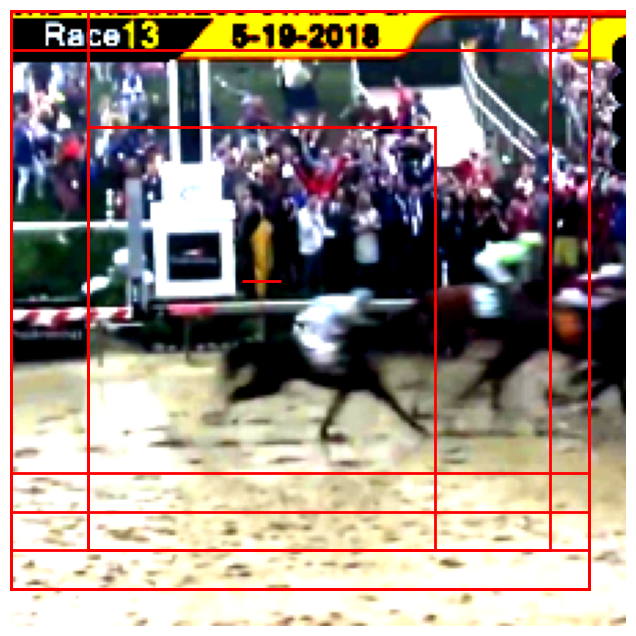

In [56]:
untrained_obj_dec = ObjectDetector(10, 768)
untrained_obj_dec.set_device(device)
with torch.no_grad():
    for tgt, _ in val_loader:
        tgt = tgt.to(device)
        feat_map, depth, slots, masks, bboxes, obj_feats, conf= untrained_obj_dec(tgt)
        for i in range(4):
            visualize_bboxes(tgt[i], bboxes[i])
        break